**Step 0 - install and import dependencies**

In [ ]:
!pip install pythainlp
!pip install tensorflow_text
!pip install umap-learn

In [ ]:
import numpy as np
import pandas as pd
import re

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import umap

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

from sklearn.feature_extraction.text import TfidfVectorizer

import pythainlp
from pythainlp.corpus.common import thai_words
from pythainlp.util import Trie
import collections


In [ ]:
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' #'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3' for a large model

model = hub.load(module_url)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("drive/MyDrive/CRM/Wongnai Reviews - Small.csv")

In [ ]:
df.head()

,Review ID,Review
0,1,เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีวันนึงเด...
1,2,Art of Coffee Kasetsart เป็นร้านกาแฟรสชาติเยี่...
2,3,กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่ค...
3,4,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...
4,5,ชอบมาทานร้านนี้ถ้าอยากกินอาหารเวียดนามใกล้บ้าน...


**Step 1 - document embedding and dimension reduction**

In [ ]:
#embed sentences using Universal Sentence Encoder (USE)

embed_comments_array = model(df['Review'].values).numpy()
embed_comments_array

array([[ 0.08993827,  0.01941084,  0.03787038, ..., -0.03488849,
         0.06299512,  0.04635989],
       [ 0.00634244,  0.00814594,  0.03071941, ..., -0.01478723,
        -0.03080936, -0.03316405],
       [ 0.0633687 , -0.02027139, -0.05077003, ..., -0.06530775,
        -0.00952999, -0.03439987],
       ...,
       [ 0.08775924,  0.03609736,  0.01263062, ..., -0.03102781,
        -0.03361677,  0.01928871],
       [ 0.05691195,  0.05381691, -0.0399575 , ..., -0.06598807,
        -0.05390478, -0.01037725],
       [ 0.0777048 ,  0.05080631,  0.02680681, ..., -0.0061413 ,
        -0.01313567,  0.02236264]], dtype=float32)

In [ ]:
#reduce array dimensions using umap (you can chagne n_components)

reducer = umap.UMAP(random_state=42,n_components=50)
umap_embed_comments_array = reducer.fit_transform(embed_comments_array)

**Step 2 - document clustering using KMeans**

Text(0, 0.5, 'WCSS')

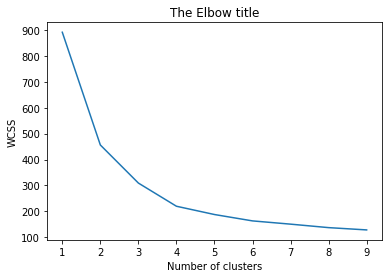

In [ ]:
#run kmeans with various number of k. evaluate no. of k based on the elbow plot

wcss=[]
max_k = 10
for i in range(1, max_k):
  kmeans = KMeans(i)
  kmeans.fit(umap_embed_comments_array)
  wcss_iter = kmeans.inertia_
  wcss.append(wcss_iter)

number_clusters = range(1, max_k)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [ ]:
#run kmeans with no. of clusters you see fit the most

k = 4

kmeans = KMeans(n_clusters = k)
kmeans.fit(umap_embed_comments_array)

df['KMeans ID'] = kmeans.labels_

In [ ]:
#merge all reviews of each cluster into one big sentence 

df_kmeans = pd.DataFrame(columns=["KMeans ID", "texts"])


for i in range(0, k):
  row = []
  row.append(i)
  row.append(df['Review'][df['KMeans ID'] == i].to_string())
  df_kmeans.loc[len(df_kmeans)] = row

In [ ]:
df_kmeans

,KMeans ID,texts
0,0,2 กวงทะเลเผา อาหารทะเลเค้าสดจริงๆเนื้อปูห...
1,1,0 เป็นคนที่ชอบทาน Macchiato เป็นประจำ มีว...
2,2,13 เคยเป็นไหมกันไหมคะ หลังอาหารมื้อใหญ่ ต่...
3,3,3 วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออก...


In [ ]:
#create regex compiler for removal of a character you don't want

special_characters = "/[!@#$%^&*'/(/)/,/[/]]/g"

specialchar_pattern = re.compile(special_characters)

In [ ]:
#create regex compiler for removal of any emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

In [ ]:
#create regex compiler for removal of digit

number_pattern = re.compile("[0-9]")

In [ ]:
#create regex compiler for removal of white space

space_pattern = re.compile("\s+")

In [ ]:
#create regex compiler for removal of .

dot_pattern = re.compile(r"\.+")

In [ ]:
#create regex compiler for removal of \

backslash_pattern = re.compile(r"\\+")

### TF-IDF

In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', \
                 'ร้านอาหาร', 'ร้านกาแฟ', 'ร้าน', 'อาหาร', 'ผม', 'ทาน', 'กิน', 'เจอ', 'เลือก', 'ซื้อ', 'อย่า', 'เกริ่น', \
                 'ซอย', 'ปากซอย', \
                 'มีโอกาส', 'สวัสดี', \
                 'กก', 'าน', 'เม', 'น', 'นขา', 'ศ', 'เค', 'เป็ร้าน', \
                 'คุง', 'ซอน', 'วัง', 'นึง', 'ไร้', 'นิว', 'ดาว', 'แนว'
                ]
                
screening_words = stopwords + removed_words

new_words = {"สตารบัก", "อะเมซอน", "เค้าดาว", 'stamp'}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, เค้า, สด, เนื้อ, ป...","[(อร่อย, 6), (ราคา, 5), (เพื่อน, 4), (ส้มตำ, 4..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[คน, ชอบ, Macchiato, เป็นประจำ, เด, ArtofCoffe...","[(กาแฟ, 19), (ชอบ, 8), (คาเฟ่, 6), (แวะ, 6), (..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[ไหม, ไหม, หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า,...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[ตื่น, เช้า, โอกาส, มาหา, อะ, ไช, อบ, เวียดนาม...","[(อร่อย, 9), (รีวิว, 7), (บ้าน, 5), (กาแฟ, 5),..."


In [ ]:
# TF-IDF
def identity_fun(text):
    return text

In [ ]:
tfidf_vectorizer = TfidfVectorizer(analyzer = 'word', #this is default
                                   tokenizer=identity_fun, #does no extra tokenizing
                                   preprocessor=identity_fun, #no extra preprocessor
                                   token_pattern=None)

tfidf_vector= tfidf_vectorizer.fit_transform(df_kmeans['texts_tokenized'])
tfidf_array = np.array(tfidf_vector.todense())

# transform to  df
df_tfidf = pd.DataFrame(tfidf_array,columns=tfidf_vectorizer.get_feature_names())
df_tfidf

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,!,!!,',(,(/คน),(คน,(คืด้วย,-,-cake,-no,/,:,>>,ALittleSweet,Aprilstore,ArtofCoffee,ArtofCoffeeKasetsart,BTS,Big-C,BigC,BlackCanyon,Brunchset,ByPupe,CP,CatCafe,Dakasi,Fukumatcha,G,HappyMan,Icecaramelmacchiato,Location,Macchiato,NearRiverGoldentriangle,OISHIbuffet,Ochaya,OrientalnP,RiceMango,SipnSurf,Starbuckn,Starbucks,...,โรงแรม,โลตัส,โอกาส,โอ้,โฮมเมด,โฮมโปร,ใจ,ใจจริง,ในเครือ,ให,ให้ได้,ไ,ไก่,ไข,ไข่,ไข่มุก,ไช,ได้ยิน,ได้ฤกษ์,ไต้หวัน,ไทย,ไปมา,ไปรษณีย์,ไปหา,ไปเที่ยว,ไพ,ไฟ,ไม่ต้อง,ไส,ไหม,ไอ,ไอติม,ไอศครีม,ไออุ่น,ๆคน(,ๆถ,ๆอร่,ๆาน,ๆๆ,์
0,0.000000,0.000000,0.000000,0.076512,0.048523,0.00000,0.048523,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048523,0.048523,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.048523,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.048523,0.038256,0.0000,0.048523,0.000000,0.000000,0.000000,0.048523,0.038256,0.00000,0.000000,0.000000,0.048523,0.000000,0.076512,0.000000,0.00000,0.000000,0.000000,0.000000,0.123886,0.000000,0.048523,0.000000,0.00000,0.048523,0.048523,0.00000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.00000
1,0.000000,0.035964,0.035964,0.000000,0.000000,0.00000,0.000000,0.00000,0.035964,0.035964,0.00000,0.085064,0.000000,0.000000,0.000000,0.035964,0.035964,0.028355,0.000000,0.000000,0.000000,0.000000,0.035964,0.035964,0.035964,0.000000,0.000000,0.035964,0.035964,0.00000,0.000000,0.035964,0.035964,0.000000,0.000000,0.000000,0.00000,0.035964,0.035964,0.035964,...,0.000000,0.028355,0.0000,0.000000,0.035964,0.000000,0.035964,0.000000,0.028355,0.00000,0.000000,0.071929,0.000000,0.000000,0.000000,0.000000,0.00000,0.028355,0.000000,0.000000,0.022956,0.022956,0.000000,0.071929,0.00000,0.000000,0.000000,0.00000,0.035964,0.000000,0.000000,0.0000,0.000000,0.000000,0.035964,0.000000,0.00000,0.035964,0.0000,0.00000
2,0.028904,0.000000,0.000000,0.028904,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.00000,0.028904,0.036662,0.036662,0.073323,0.000000,0.000000,0.028904,0.036662,0.036662,0.000000,0.000000,0.000000,0.000000,0.000000,0.073323,0.036662,0.000000,0.000000,0.00000,0.036662,0.000000,0.000000,0.000000,0.073323,0.036662,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.036662,0.000000,0.000000,0.000000,0.00000,0.036662,0.000000,0.000000,0.036662,0.000000,0.513262,0.00000,0.028904,0.036662,0.109985,0.000000,0.023401,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.073323,0.036662,0.0000,0.036662,0.036662,0.000000,0.036662,0.00000,0.000000,0.0000,0.00000
3,0.038987,0.000000,0.000000,0.000000,0.000000,0.04945,0.000000,0.04945,0.000000,0.000000,0.04945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04945,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04945,0.000000,0.000000,0.000000,0.000000,0.038987,0.000000,0.04945,0.000000,0.000000,0.000000,0.031563,0.063126,0.000000,0.000000,0.04945,0.000000,0.000000,0.04945,0.000000,0.000000,0.000000,0.0989,0.000000,0.000000,0.000000,0.000000,0.04945,0.000000,0.0989,0.04945


In [ ]:
# top 10 TF-IDF
print(df_tfidf.apply(lambda s: s.nlargest(10).index.tolist(), axis=1).ravel()) 

[list(['แซ่บ', 'ราคา', 'ส้มตำ', 'อร่อย', 'ดีล', 'ยำ', 'เก่าแก่', 'เป็ด', 'รสชาติ', 'เพื่อน'])
 list(['กาแฟ', 'คาเฟ่', 'ชอบ', 'พาย', 'เบเกอรี่', 'น่ารัก', 'บรรยากาศ', 'แวะ', 'จิบ', 'รอ'])
 list(['นม', 'ไข่มุก', 'ชา', 'ไต้หวัน', 'เครื่องดื่ม', 'Aprilstore', 'Dakasi', 'Ochaya', 'ชาเขียว', 'สยาม'])
 list(['อร่อย', 'รีวิว', 'บ้าน', 'คิว', 'กาแฟ', 'ชอบ', 'ขนมปัง', 'ปีใหม่', 'เด็ด', 'แตงโม'])]


### Manual remove

In [ ]:
#define a function to tokenize a sentence into words - you can define words you want to remove as well as new words for tokenization

stopwords = list(pythainlp.corpus.thai_stopwords())
removed_words = ['u', 'b', 'n', 'nn', 'nn-', '\n', \
                 'ร้านอาหาร', 'ร้านกาแฟ', 'ร้าน', 'อาหาร', 'น้ำ', 'ทาน', 'กิน', 'ราคา', 'เติม', 'เมนู', 'อร่อย', \
                 'ผม', 'เจอ', 'เลือก', 'ซื้อ', 'ขาย', 'หา', 'อย่า', 'เกริ่น', 'เดิน', 'รีวิว', 'พูดถึง', 'คน', 'ดี', 'ชอบ', 'รู้จัก', 'สำหรับ', 'ชื่อ', \


                 'ซอย', 'ปากซอย', 'ตั้งอยู่', 'ถนน', 'รอบ', 'แถว', 'สาขา', 'ชั้น', \
                 'มีโอกาส', 'โอกาส', 'สวัสดี', \
                 'กก', 'าน', 'เม', 'น', 'นขา', 'ศ', 'เค', 'เป็ร้าน', 'ร้า', 'กา', 'อ', 'ส', 'บอ', 'รา', 'ร', 'ห', 'เด', 'ๆๆ', ':', 'เก', 'รี่', 'ท', \
                 'คุง', 'ซอน', 'วัง', 'นึง', 'ไร้', 'นิว', 'ดาว', 'แนว', 'นะคะ', 'ไหม', 'กร้าน', 'เค้า'
                ]

screening_words = stopwords + removed_words

new_words = {"สตารบัก", "อะเมซอน", "เค้าดาว", 'stamp', 'เบเกอรี่'}

words = new_words.union(thai_words())

custom_dictionary_trie = Trie(words)

def tokenize_to_list(sentence):
  merged = []
  words = pythainlp.word_tokenize(str(sentence), engine='newmm', custom_dict=custom_dictionary_trie)
  for word in words:
    if word not in screening_words:
      merged.append(word)
  return merged

In [ ]:
#clean and tokenize sentences. count the occurences of each word

df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: emoji_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: specialchar_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: number_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: space_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: dot_pattern.sub(r'', x))
df_kmeans['texts'] = df_kmeans['texts'].apply(lambda x: backslash_pattern.sub(r'', x))
df_kmeans['texts_tokenized'] = df_kmeans['texts'].apply(lambda x: tokenize_to_list(x))
df_kmeans['texts_count'] = df_kmeans['texts_tokenized'].apply(lambda x: collections.Counter(x).most_common())

In [ ]:
#results of tokenization

df_kmeans

,KMeans ID,texts,texts_tokenized,texts_count
0,0,กวงทะเลเผาอาหารทะเลเค้าสดจริงๆเนื้อปูหวานไม่คส...,"[กวง, ทะเล, เผา, อาหารทะเล, สด, เนื้อ, ปู, หวา...","[(เพื่อน, 4), (ส้มตำ, 4), (ไทย, 4), (แซ่บ, 4),..."
1,1,เป็นคนที่ชอบทานMacchiatoเป็นประจำมีวันนึงเดArt...,"[Macchiato, เป็นประจำ, ArtofCoffeeKasetsart, ร...","[(กาแฟ, 19), (คาเฟ่, 6), (แวะ, 6), (น่ารัก, 5)..."
2,2,เคยเป็นไหมกันไหมคะหลังอาหารมื้อใหญ่ต่อให้อิ่เช...,"[หลังอาหาร, มื้อ, ต่อให้, อิ่, เช้า, บ่าย, เย็...","[(ชา, 18), (นม, 14), (ไข่มุก, 14), (เครื่องดื่..."
3,3,วันนี้มีโอกาสตื่นเช้าครับเลยถึงโอกาสออกมาหาอะไ...,"[ตื่น, เช้า, มาหา, อะ, ไช, อบ, เวียดนาม, บ้าน,...","[(บ้าน, 5), (กาแฟ, 5), (คิว, 3), (ครั้งแรก, 3)..."


In [ ]:
#show top keywords of each cluster

top_N_words = 10

for i in range(0, len(df_kmeans)):
  print(f"Cluster ID : {i}\n")
  print(f"Most common words include : {list(df_kmeans['texts_count'][i])[:top_N_words]}\n")

#tune a model by remove unwanted characters and words and add more words to a custom dictionary

Cluster ID : 0

Most common words include : [('เพื่อน', 4), ('ส้มตำ', 4), ('ไทย', 4), ('แซ่บ', 4), ('รสชาติ', 4), ('ยำ', 3), ('เก่าแก่', 3), ('เป็ด', 3), ('ดีล', 3), ('กาแฟ', 3)]

Cluster ID : 1

Most common words include : [('กาแฟ', 19), ('คาเฟ่', 6), ('แวะ', 6), ('น่ารัก', 5), ('นั่ง', 5), ('เบเกอรี่', 4), ('พาย', 4), ('บรรยากาศ', 4), ('รสชาติ', 3), ('เค้ก', 3)]

Cluster ID : 2

Most common words include : [('ชา', 18), ('นม', 14), ('ไข่มุก', 14), ('เครื่องดื่ม', 4), ('ลอง', 3), ('ไต้หวัน', 3), ('แวะ', 2), ('ชาเขียว', 2), ('Ochaya', 2), ('Aprilstore', 2)]

Cluster ID : 3

Most common words include : [('บ้าน', 5), ('กาแฟ', 5), ('คิว', 3), ('ครั้งแรก', 3), ('ลอง', 3), ('เช้า', 2), ('สะดุดตา', 2), ('ทะเล', 2), ('ไอติม', 2), ('เวลา', 2)]



**Step 4 - result discussion**

ผลที่ได้สอดคล้องกับการทำ TF-IDF

Cluster 0 : พูดถึงร้านอาหารไทย แซ่บๆ ที่กินกะเพื่อน

Cluster 1 : พูดถึงคาเฟ่ขาย กาแฟ เบเกอรี่ ที่บรรยากาศดี 

Cluster 2 : พูดถึงชาต่างๆ เช่น ชานม ชาไต้หวัน ชาเขียว รวมถึง Hand craft coffee

Cluster 3 : พูดเกี่ยวกับเรื่องการรีวิวร้านที่มาครั้งแรก